# Temperature global map

This notebook gets the spatial variability in the temperature error, relative to a control ensemble.

# 1. Process raw data

In [15]:
import glob
import xarray as xr
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import sys


#Functions

def get_global_weights():
    
     #Get the latitude weights from a special location
    r1 = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/Fig1_10year_Williams/'
    f = r1 + 'speedyoneWILLIAMS_L2_52_RN_10y/model_output00001.nc'
    df = xr.open_dataset(f)
    
    temperature = df.temperature    
    return temperature.latitude



    
def process_nc_file(f,correct_latitude_values):    
    
    #Get data 
    ds = xr.open_dataset(f)
    
        
    #Reset the latitude
    ds = ds.assign_coords(latitude=(correct_latitude_values))
    #And covert longitude to long1
    ds = ds.assign_coords({"longitude": (((ds.longitude + 180) % 360) - 180)})
    

    # Just get the precip
    LSP = ds.large_scale_precipitation * (6*60*60) / 1000 #mm / 6h
    CVP = ds.convective_precipitation  * (6*60*60) / 1000 #mm / 6h              
    precip = LSP + CVP

    if LSP.shape != (365, 48, 96):
        return False #Exit function and don't use this one
    
    df = precip.to_dataframe("precip").reset_index()   # And make it a df
    
    df['weight']= np.cos(np.deg2rad(df.latitude))           # Get weights
    df['weighted_precip']=  df.weight*df.precip   # And weighted temperature
    
    df_out = df.groupby(['latitude', 'longitude']).mean().reset_index() #i.e. average over 1 year    
    ds.close()
    return df_out
    

def global_average(list_of_files,p):
    
    """
    Average over all ensemble members (m0,m1 etc) and all times
    """

    
    # Get the global weights at full precision.
    correct_latitude_values = get_global_weights()
    
    
    dfs = []
    for n in tqdm(list_of_files):
        precipitation = process_nc_file(n,correct_latitude_values) # this is a df of the surface temperature for that file, averaged over the year
        if precipitation is not False:   #False if the shape isnt correct
                dfs.append(precipitation)
          
    #Concat everything together
    df = pd.concat(dfs)
    
    #Groupby
    df_g = df.groupby(['latitude', 'longitude']).mean().reset_index() #i.e. average over all time and ensemble members
    
    #Save it  
    fname = f'data/{p}_global_average_map_precip.pkl'
    print('ALl iterations completed. Now saving to file:', fname)
    pd.to_pickle(df_g,fname)
    
    return df_g
    
    



In [16]:
#First get control
root= f'/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/100year/'
control_files = sorted(glob.glob(root + 'tmp_control/*/model_output*.nc'))
dfcontrol = global_average(control_files,'control')

  0%|          | 0/503 [00:00<?, ?it/s]

ALl iterations completed. Now saving to file: data/control_global_average_map_precip.pkl


In [17]:
competitor_52RN_files = sorted(glob.glob(root+'tmp_m*/speedyone100yr_L2_52_RN_*/model_output*.nc'))      #Un nested
competitor_10SR_files = sorted(glob.glob(root+'tmp_m*/speedyone100yr_L2_10_SR_*/**/model_output*.nc'))   #Nested
competitor_10RN_files = glob.glob(root + f'tmp_m*/speedyone100yr_L2_10_RN_*/model_output*.nc') + glob.glob(root + f'tmp_m*/speedyone100yr_L2_10_RN_*/**/model_output*.nc') #Both


#For now, dont use m9 files
competitor_52RN_files_m9 = sorted(glob.glob(root+'tmp_m9/speedyone100yr_L2_52_RN_m9/model_output*.nc'))  
competitor_10SR_files_m9 = sorted(glob.glob(root+'tmp_m9/speedyone100yr_L2_10_SR_m9/**/model_output*.nc'))  
competitor_10RN_files_m9 = sorted(glob.glob(root+'tmp_m9/speedyone100yr_L2_10_RN_m9/**/model_output*.nc'))  


competitor_52RN_files = sorted(list(set(competitor_52RN_files) - set(competitor_52RN_files_m9))) 
competitor_10SR_files = sorted(list(set(competitor_10SR_files) - set(competitor_10SR_files_m9))) 
competitor_10RN_files = sorted(list(set(competitor_10RN_files) - set(competitor_10RN_files_m9))) 



In [18]:
df52 = global_average(competitor_52RN_files,'52RN')
dfSR = global_average(competitor_10SR_files,'10SR')
df10 = global_average(competitor_10RN_files,'10RN')

  0%|          | 0/404 [00:00<?, ?it/s]

ALl iterations completed. Now saving to file: data/52RN_global_average_map_precip.pkl


  0%|          | 0/417 [00:00<?, ?it/s]

ALl iterations completed. Now saving to file: data/10SR_global_average_map_precip.pkl


  0%|          | 0/408 [00:00<?, ?it/s]

ALl iterations completed. Now saving to file: data/10RN_global_average_map_precip.pkl


# 2. Plot it

In [50]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

def RobinsonPlotDev(df,cmap,lower_limit, upper_limit,nlevs,savefig,show_cbar):
    
    
    
    dftmp = df[['latitude','longitude','weighted_precip']].copy() #Make a copy
    dfpivot = dftmp.pivot('longitude', 'latitude') #Pivot onto lon/lat

    #Extract data into arrays
    lat=dfpivot.columns.levels[1].values
    lon=dfpivot.index.values
    data=dfpivot.values.T


    #Setup plotting env
    fig = plt.figure(figsize=[24,12])
    ax = plt.subplot(projection=ccrs.Robinson(central_longitude=0))
    
    
    if (lower_limit is None) & (upper_limit is None):
        levels = nlevs
    else:
        levels = np.linspace(lower_limit,upper_limit,nlevs)
    

    data, lon = add_cyclic_point(data, coord=lon) #https://stackoverflow.com/questions/56348136/white-line-in-contour-plot-in-cartopy-on-center-longitude
    contourf_ = ax.contourf(lon, lat, data,levels=levels,transform=ccrs.PlateCarree(central_longitude=0),cmap=cmap) #this has to be PlateCarree https://stackoverflow.com/questions/56761472/lack-of-projection-for-cartopy-contour
    
    print ('Limits:', min(data.flatten()), max(data.flatten()))
    
    if show_cbar:
        cb = fig.colorbar(contourf_,orientation="horizontal",ax=ax,fraction=0.046, pad=0.04,ticks=[-1, 0, 1])
        cb.ax.tick_params(labelsize=16)
        cb.set_label('mm / 6h',fontsize=16)
    #tick_params(labelsize=font_size)
    ax.coastlines()
    if savefig is not None:
        plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)
    
    plt.show()
    

In [25]:
dfcontrol = pd.read_pickle('data/control_global_average_map_precip.pkl')
df52 = pd.read_pickle('data/52RN_global_average_map_precip.pkl')
dfSR = pd.read_pickle('data/10SR_global_average_map_precip.pkl')
df10 = pd.read_pickle('data/10RN_global_average_map_precip.pkl')

Limits: 0.00020715612041231467 5.4463545063897065


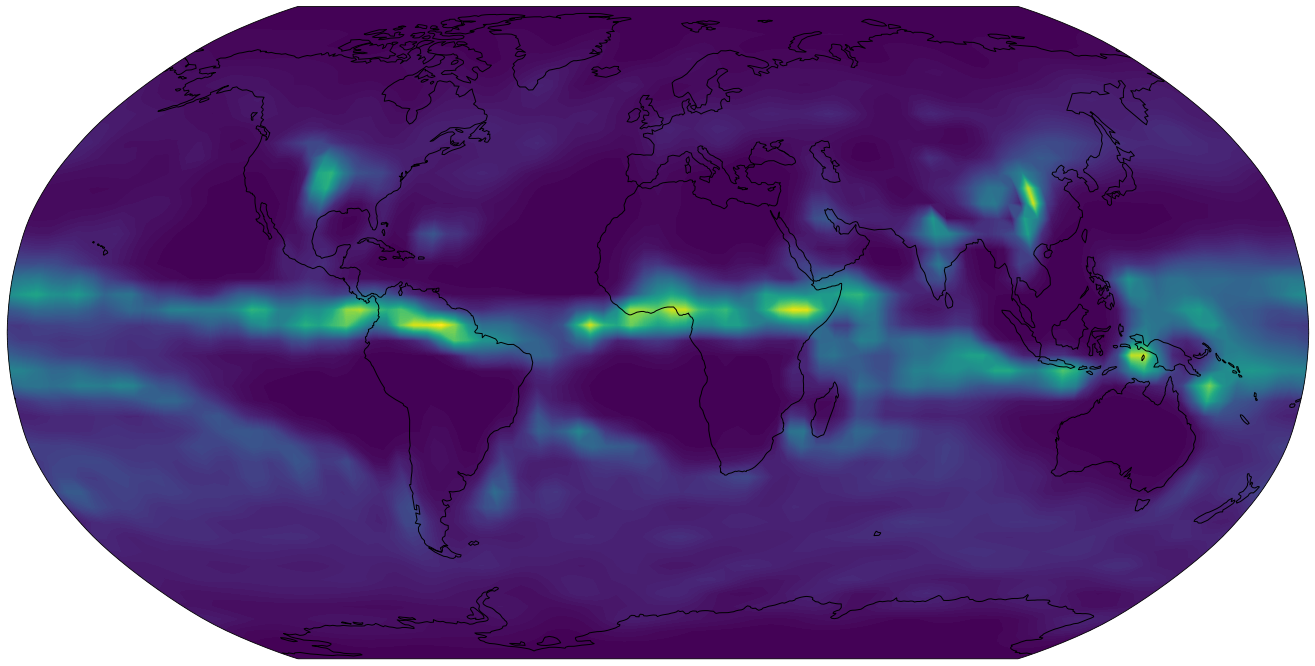

Limits: 0.0002582988529468812 5.5394491132186054


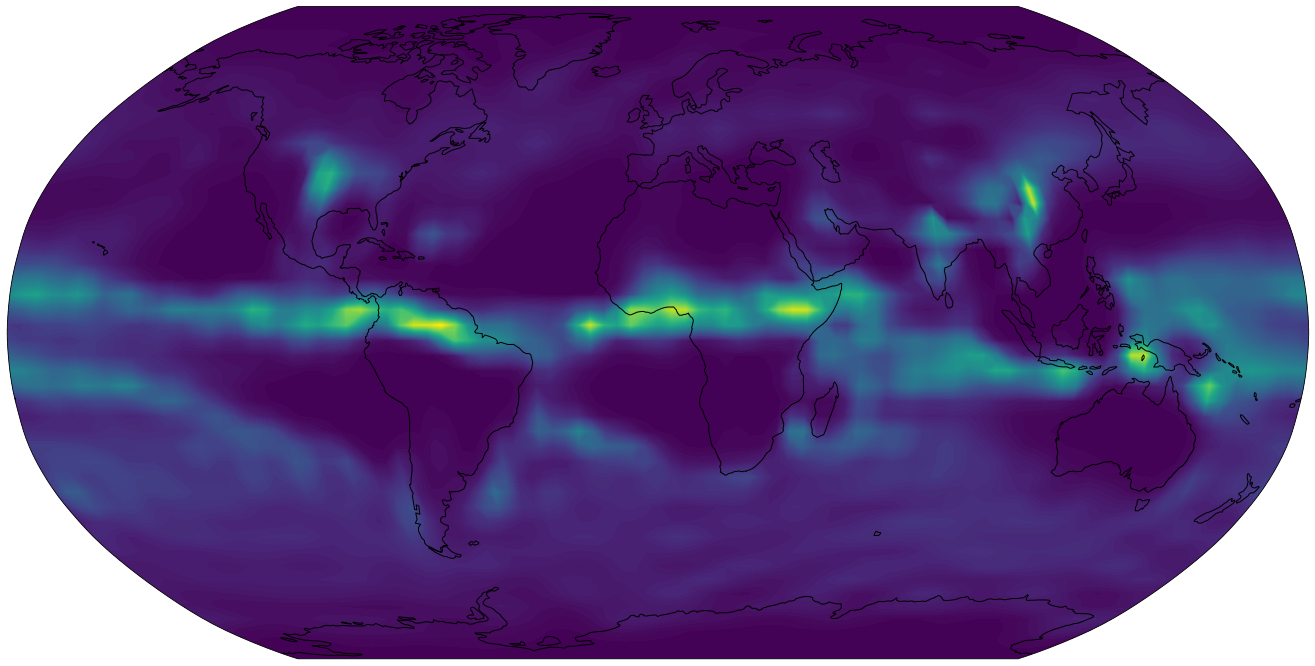

Limits: 0.0001670783628871683 5.434054901059711


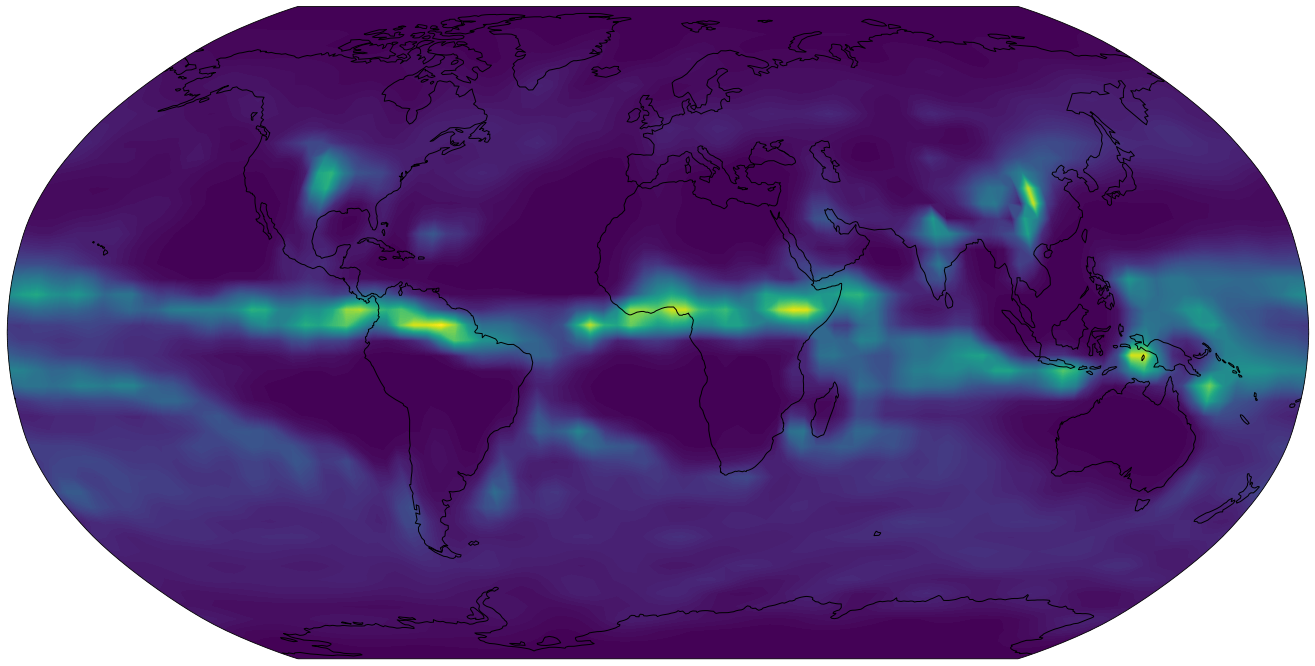

Limits: 0.00019248163795239904 5.618984161171246


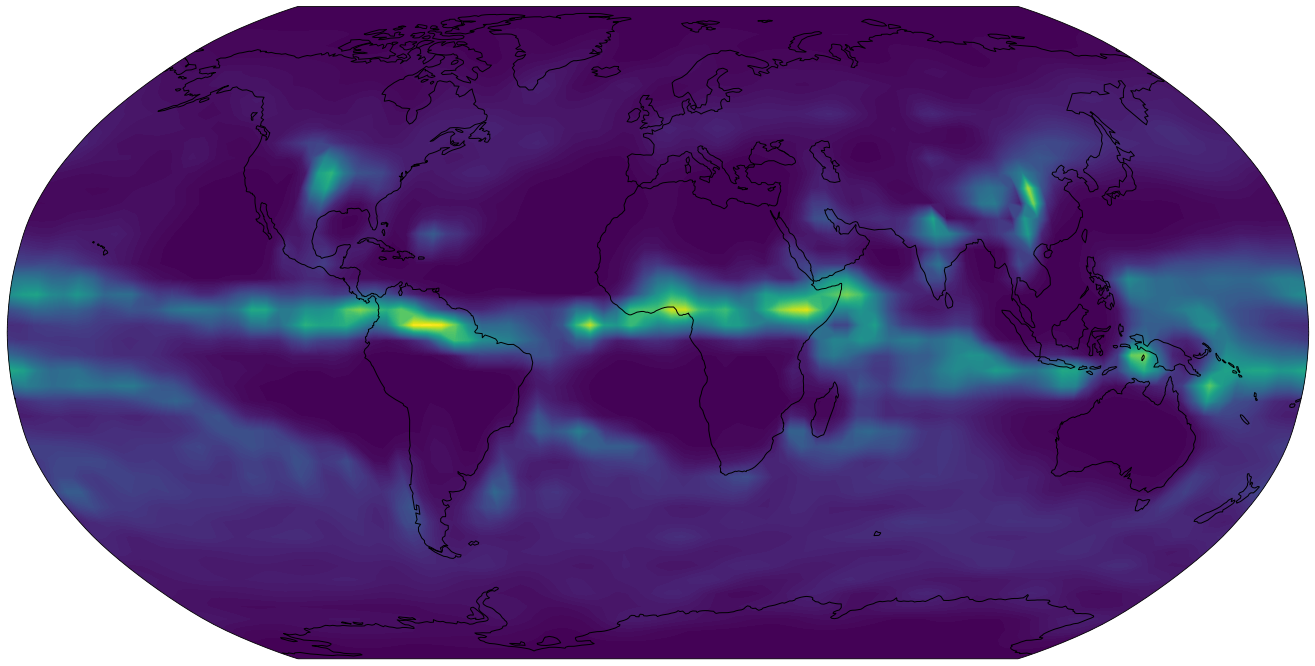

In [26]:
RobinsonPlotDev(dfcontrol,plt.cm.viridis, lower_limit=None, upper_limit=None, nlevs = 100,savefig=None,show_cbar=False)
RobinsonPlotDev(df52,     plt.cm.viridis, lower_limit=None, upper_limit=None, nlevs = 100,savefig=None,show_cbar=False)
RobinsonPlotDev(dfSR,     plt.cm.viridis, lower_limit=None, upper_limit=None, nlevs = 100,savefig=None,show_cbar=False)
RobinsonPlotDev(df10,     plt.cm.viridis, lower_limit=None, upper_limit=None, nlevs = 100,savefig=None,show_cbar=False)

In [41]:

#Subtract one from other
subs52 = dfcontrol.copy()
subs52['weighted_precip'] = dfcontrol.weighted_precip - df52.weighted_precip

subsSR = dfcontrol.copy()
subsSR['weighted_precip'] = dfcontrol.weighted_precip - dfSR.weighted_precip

subs10 = dfcontrol.copy()
subs10['weighted_precip'] = dfcontrol.weighted_precip - df10.weighted_precip


Limits: -0.09309460682889892 0.07414048256518324


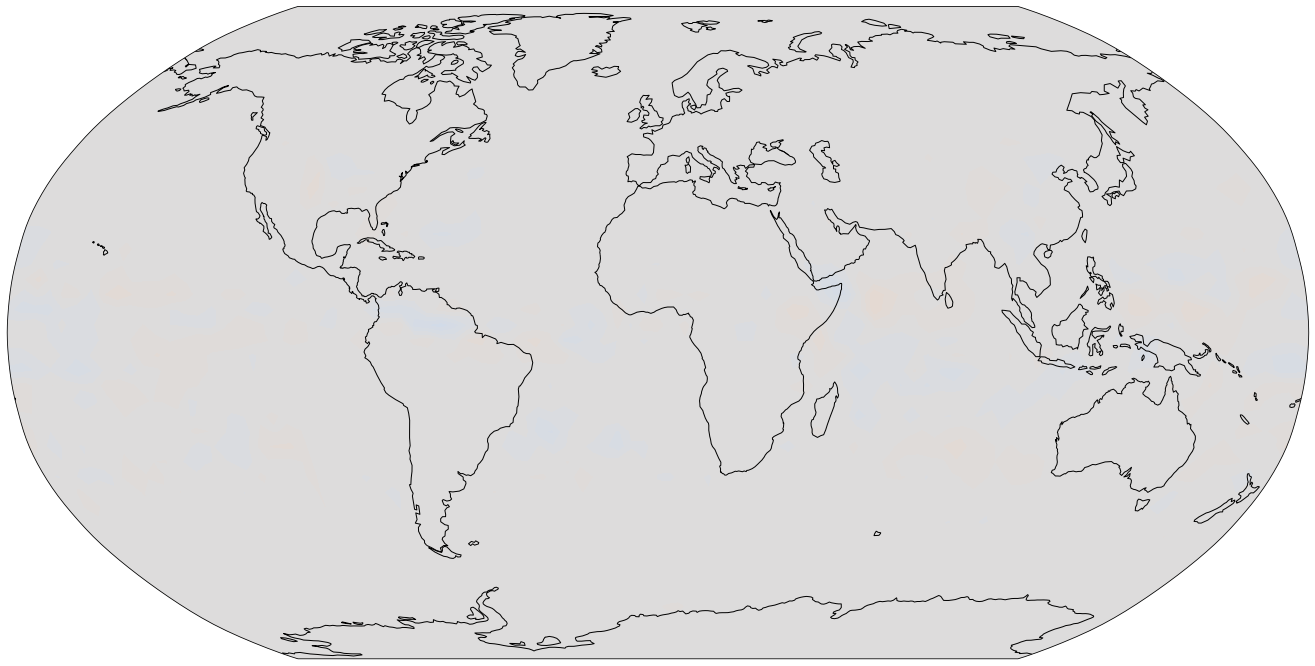

Limits: -0.1640047994208249 0.16876426822800816


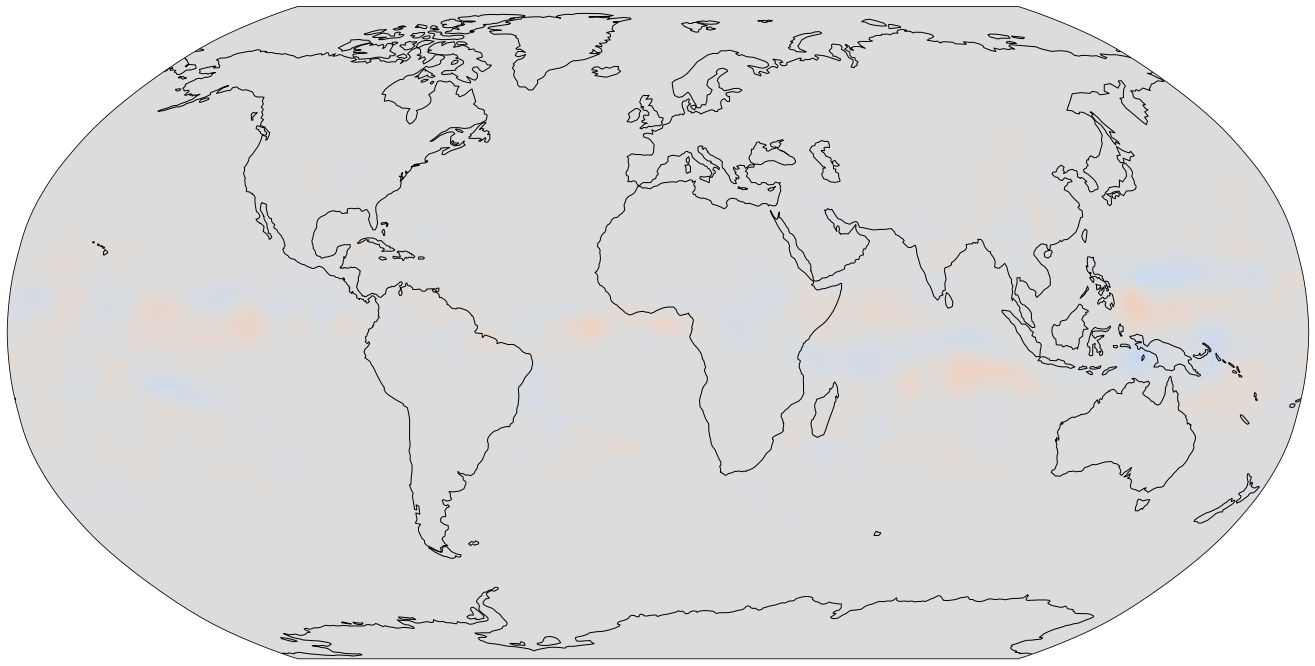

Limits: -1.0741427343672765 0.8264404784650496


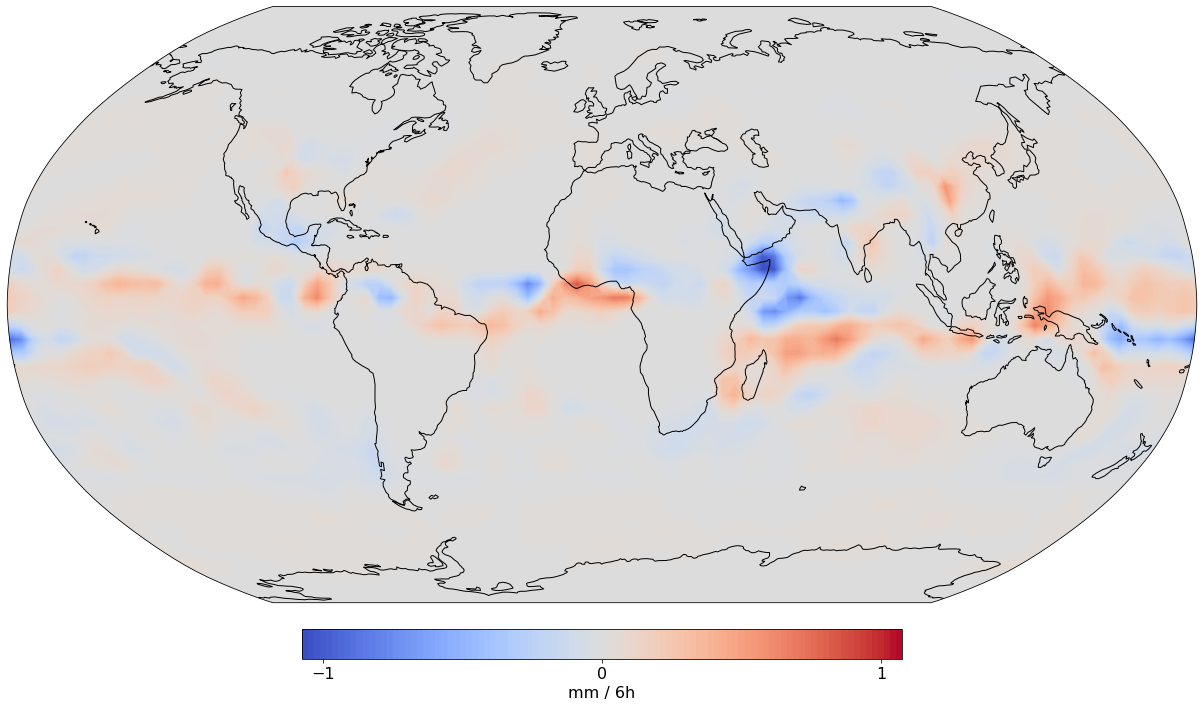

In [57]:
RobinsonPlotDev(subs52,plt.cm.coolwarm, lower_limit=subs10.weighted_precip.min(), upper_limit=-subs10.weighted_precip.min(), nlevs = 100,savefig='figures/MolMap52_precip.png',show_cbar=False)
RobinsonPlotDev(subsSR,plt.cm.coolwarm, lower_limit=subs10.weighted_precip.min(), upper_limit=-subs10.weighted_precip.min(), nlevs = 100,savefig='figures/MolMapSR_precip.png',show_cbar=False)
RobinsonPlotDev(subs10,plt.cm.coolwarm, lower_limit=subs10.weighted_precip.min(), upper_limit=-subs10.weighted_precip.min(), nlevs = 100,savefig='figures/MolMap10_precip.png',show_cbar=True)

Limits: -1.0741427343672765 0.8264404784650496


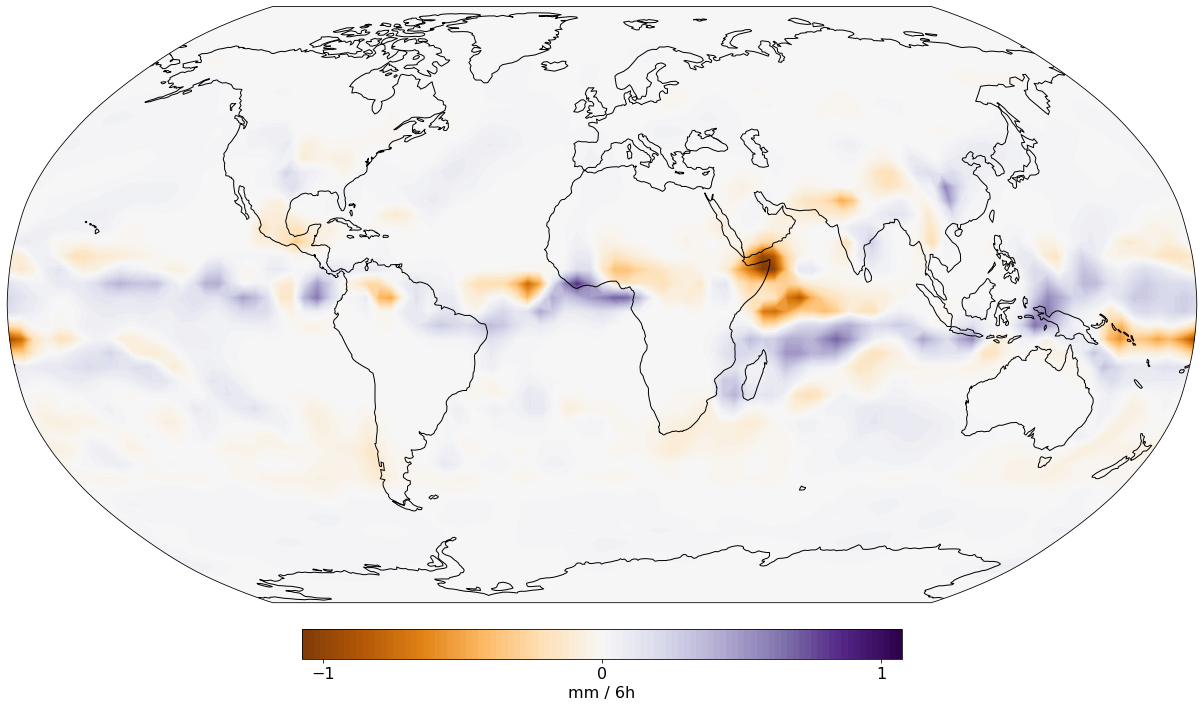

In [58]:
RobinsonPlotDev(subs10,plt.cm.PuOr, lower_limit=subs10.weighted_precip.min(), upper_limit=-subs10.weighted_precip.min(), nlevs = 100,savefig=None,show_cbar=True)

Limits: -1.0741427343672765 0.8264404784650496


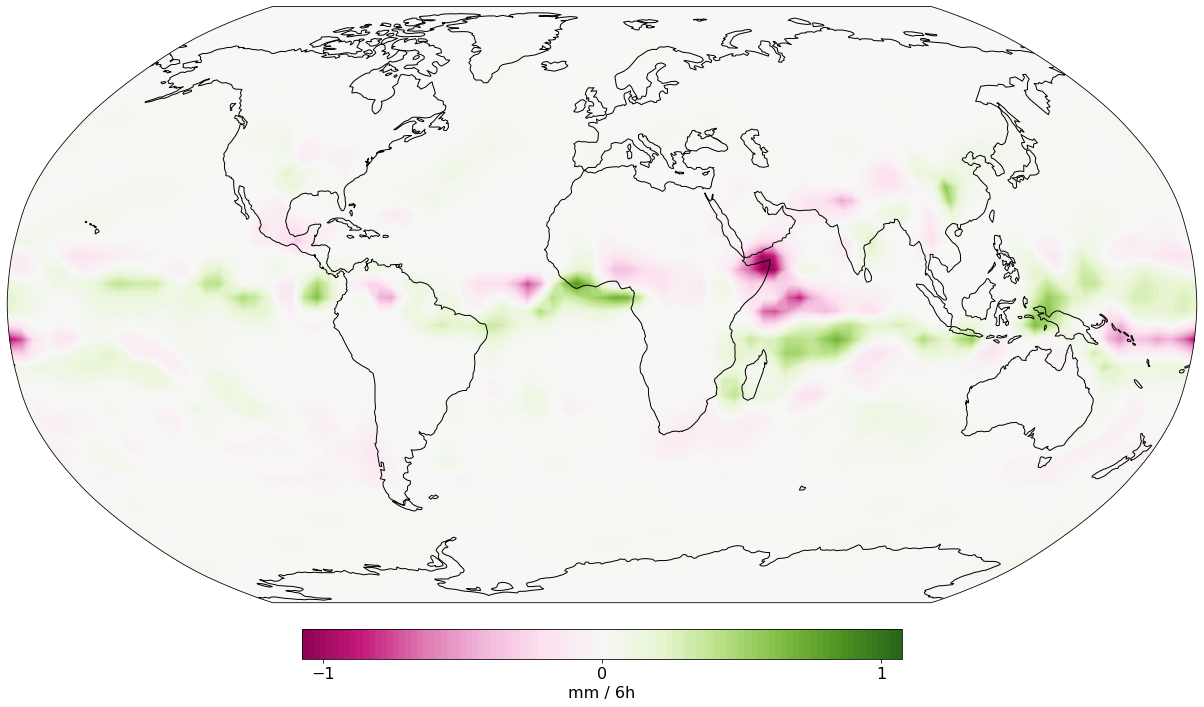

In [60]:
RobinsonPlotDev(subs10,plt.cm.PiYG, lower_limit=subs10.weighted_precip.min(), upper_limit=-subs10.weighted_precip.min(), nlevs = 100,savefig=None,show_cbar=True)

Limits: -1.0741427343672765 0.8264404784650496


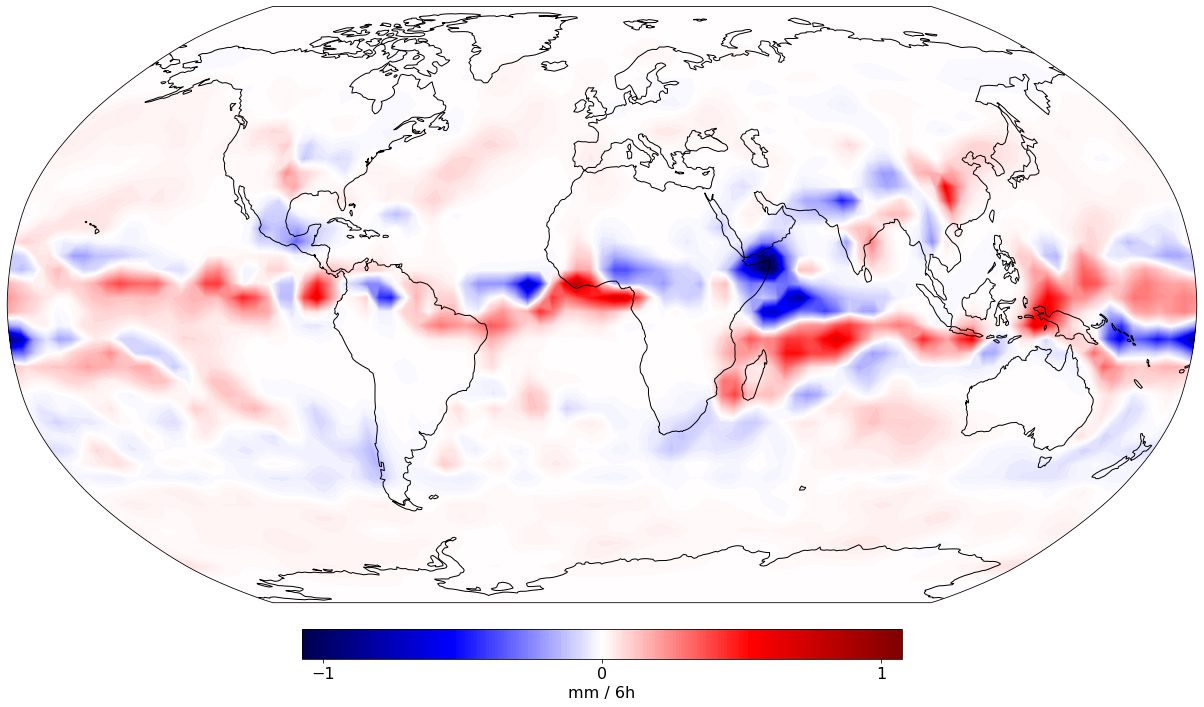

In [62]:
RobinsonPlotDev(subs10,plt.cm.seismic, lower_limit=subs10.weighted_precip.min(), upper_limit=-subs10.weighted_precip.min(), nlevs = 200,savefig=None,show_cbar=True)

Limits: -1.0741427343672765 0.8264404784650496


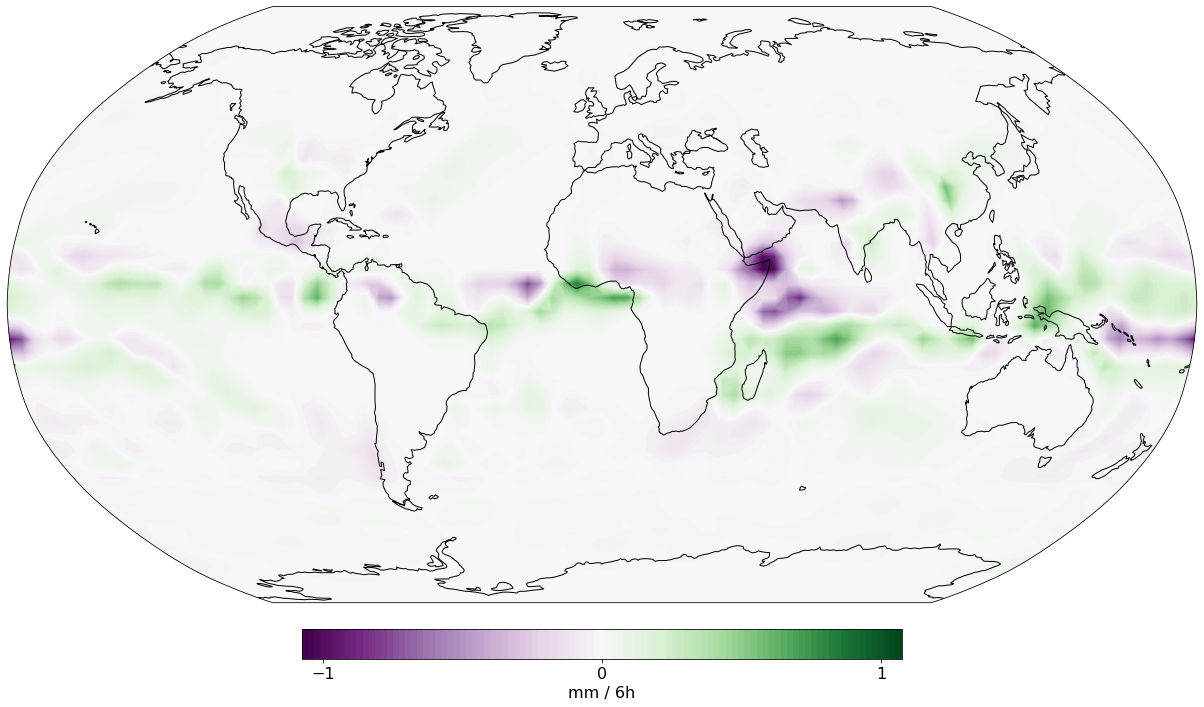

In [63]:
RobinsonPlotDev(subs10,plt.cm.PRGn, lower_limit=subs10.weighted_precip.min(), upper_limit=-subs10.weighted_precip.min(), nlevs = 100,savefig=None,show_cbar=True)